## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [130]:
half = sym.Rational(1,2)

b_modes = 2
t_modes = 2

# lets go for B2T2 (so 5 DoF)
p = mf.ModelParameters.DynamicModel(b_modes + t_modes +1)

## Create some global parameters
p.c = mf.ModelSymbol(value = 0.15,string = 'c') # chord of wing

p.m_t = mf.ModelSymbol(value = 2.75,string = 'm_t') # total mass of the wing
p.s_t = mf.ModelSymbol(value = 1.345,string = 's_t') # chord of wing

p.rho_t = p.m_t/p.s_t

p.ratio_fwt = mf.ModelSymbol(value = 0.345/1.345,string = 'sigma') # chord of wing

# main Wing Structural Parameters
p.y_0 = sym.Symbol('y_0')
p.x_0 = sym.Symbol('x_0')

p.e_0 = mf.ModelSymbol(value = 0.25,string = 'e_0')
p.x_f0 = mf.ModelSymbol(value = 0.5,string = 'x_f0')
#p.x_f0 = sym.Rational(1,4)*p.c + p.e_0*p.c

p.s_0 = p.s_t*(1-p.ratio_fwt) # mf.ModelSymbol(value = 1,string = 's_0') # chord of wing


p.s_1 = p.s_t*p.ratio_fwt # mf.ModelSymbol(value = 0.345,string = 's_1') # chord of wing
p.m_1 = p.m_t*p.ratio_fwt # mf.ModelSymbol(value = 0.3,string = 'm_1')
p.I_xx_1 = sym.Rational(1,12)*p.m_1*p.s_1**2 # inertia of FWT (uniform bar)


## force soome frequencies
p.f_0 = mf.ModelSymbol(value = 2,string = 'f_0') # first Bending mode frequency
p.EI = (2*sym.pi*p.f_0/sym.Float(3.516))**2*p.m_t*(p.s_t)**3
#p.EI = mf.ModelSymbol(value = 59.375,string = 'EI')

p.f_1 = mf.ModelSymbol(value = 4,string = 'f_1') # first Bending mode frequency
p.I_0 = p.rho_t*p.c*(half*p.rho_t-p.x_f0)
#p.GJ = (sym.Rational(4,3)*p.f_1*(p.s_0+p.s_1))**2*p.I_0
p.GJ = mf.ModelSymbol(value = 855.625,string = 'GJ')

## FWTD Structural Parameters
p.y_1 = sym.Symbol('y_1')
p.x_1 = sym.Symbol('x_1')

p.e_1 = mf.ModelSymbol(value = 0.25,string = 'e_1')
p.x_f1 = sym.Rational(1,4)*p.c + p.e_1*p.c
p.Lambda = mf.ModelSymbol(value = np.deg2rad(10),string = 'Lambda')

## Aero Parameters
p.rho = mf.ModelSymbol(value = 1.225,string = 'rho') # density
p.V = mf.ModelSymbol(value = 10,string = 'V') # velocity
p.g  = mf.ModelSymbol(value = 9.81,string = 'g') # gravity
p.alpha_r = mf.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = mf.ModelSymbol(value = 1.2,string = 'M_thetadot')


## Main Wing Specific
p.a_0 = mf.ModelSymbol(value = 2*np.pi,string = 'a_0') # C_L of wing

## FWT Specific
p.a_1 = p.a_0 - p.a_0/p.s_1*p.y_1
p.alpha_1 = mf.ModelSymbol(value = 0,string = 'alpha_1') # FWT alpha
p.alphadot_1 = mf.ModelSymbol(value = 0,string = 'alphadot_1') # FWT alphadot


## Numeric Model Constants
p.fp = mf.ModelMatrix(value =[0]*p.qs*2,symbols=sym.symbols(f'qtilde:{p.qs*2}')) # The stationary point


#### Create Transforms

In [131]:
#get shape functions for main wing
p.eta = mf.ModelMatrix(value = [1]*b_modes+[1]*t_modes,symbols=sym.symbols(f'eta:{p.qs}'))# [1]*b_modes+[1e3]*t_modes#[p.EI**2]*b_modes+[p.GJ**2]*t_modes
z_0,tau_0 = mf.ShapeFunctions_BN_TM(b_modes,t_modes,p.q[:-1],p.y_0,p.x_0,p.x_f0,0,factor=p.eta)

#define wrefernce frames
wing_root_frame = mf.HomogenousTransform().R_y(p.alpha_r)
wing_aero_frame = wing_root_frame.Translate(p.x_0,p.y_0,z_0).subs({p.x_0:p.x_f0})
wing_tip_frame = wing_aero_frame.subs({p.y_0:p.s_0})
fwt_root_frame = wing_tip_frame.R_x(-p.q[-1])
fwt_com_frame = fwt_root_frame.Translate(0,p.s_1/2,0)

#Create Elemnts
M_wing = ele.MassMatrix(p.rho_t/p.c)
M_fwt = ele.MassMatrix(p.m_1,I_xx = p.I_xx_1)

inner_wing_ele = ele.FlexiElement(wing_root_frame,M_wing,p.x_0,p.y_0,z_0,p.c,p.s_0,p.x_f0,p.EI,p.GJ)
fwt_ele = ele.RigidElement(fwt_com_frame,M_fwt,True)


# Create Gravity forces
wing_GravityForces = ef.ContinuousGravityForce(p,wing_aero_frame,
                                                sym.Matrix([0,0,-p.g*p.rho_t/p.c]),(p.x_0,0,p.c),(p.y_0,0,p.s_0))

# Create AeroForces
wing_AeroForces = ef.AeroForce.Generate(p,wing_aero_frame,p.a_0,(p.y_0,0,p.s_0),
                               alphadot = tau_0 if isinstance(tau_0,int) else tau_0.diff(me.dynamicsymbols._t),
                               M_thetadot = p.M_thetadot,
                               e = p.e_0,
                               rootAlpha = p.alpha_r,
                               deltaAlpha = tau_0,
                               alpha_zero = 0)


tau_s0 = tau_0 if isinstance(tau_0,int) else tau_0.subs(p.y_0,p.s_0)
alpha_fwt = tau_s0 + p.alpha_1
alphadot_fwt = tau_s0 if isinstance(tau_0,int) else tau_s0.diff(me.dynamicsymbols._t) + p.alphadot_1

fwt_AeroForces = ef.AeroForce.Generate(p,fwt_root_frame.Translate(0,p.y_1,0),p.a_1,(p.y_1,0,p.s_1),
                               alphadot = alphadot_fwt,
                               M_thetadot = p.M_thetadot,
                               e = p.e_1,
                               rootAlpha = alpha_fwt,
                               deltaAlpha = 0,
                               alpha_zero = 0)

In [132]:
#Create Composite force
CompositeForce = ef.CompositeForce(p,[wing_AeroForces,fwt_AeroForces,wing_GravityForces])
# Create the SYmbolic Model
sm = mf.SymbolicModel.FromElementsAndForces(p,[inner_wing_ele,fwt_ele],CompositeForce)

In [133]:
sm.f.jacobian(p.q)



⎡                   2      4  2                              2      5  2      
⎢1.29426214762095⋅f₀ ⋅mₜ⋅sₜ ⋅π ⋅(1 - σ)   1.94139322143143⋅f₀ ⋅mₜ⋅sₜ ⋅π ⋅(1 - 
⎢──────────────────────────────────────   ────────────────────────────────────
⎢                   2                                      η₀⋅η₁              
⎢                 η₀                                                          
⎢                                                                             
⎢                   2      5  2        2                     2      6  2      
⎢1.94139322143143⋅f₀ ⋅mₜ⋅sₜ ⋅π ⋅(1 - σ)   3.88278644286286⋅f₀ ⋅mₜ⋅sₜ ⋅π ⋅(1 - 
⎢───────────────────────────────────────  ────────────────────────────────────
⎢                 η₀⋅η₁                                       2               
⎢                                                           η₁                
⎢                                                                             
⎢                                                   

# Setup Numeric Model Parameters


In [140]:
tmax, dt = 5, 0.01

#set velocity and alpha_r funcs
def Vfunc(t,x):
    return 18

def arfunc(t,x):
    return np.deg2rad(5)
    #return np.deg2rad(5)+np.sin(2*np.pi*1*t)*np.deg2rad(5)
    
## Get functions for Fwt AoA and its derivative
fwt_aoa = mf.GetAoA(p.alpha_r,0,p.Lambda.value,p.q[-1])
FwtAoA = sym.lambdify((p.alpha_r,p.x),fwt_aoa)
DotFwtAoA = sym.lambdify((p.alpha_r,p.x),fwt_aoa.diff(me.dynamicsymbols._t))

# p.alpha_1.value = lambda t,x:FwtAoA(arfunc(t,x),x)
# p.alphadot_1.value = lambda t,x:DotFwtAoA(arfunc(t,x),x)

#p.alpha_1 = mf.ModelExpr(value = fwt_aoa,func = lambda t,x:FwtAoA(arfunc(t,x),x),string = 'alpha_1' )
#p.alphadot_1 = mf.ModelExpr(value = fwt_aoa.diff(t),func = lambda t,x:DotFwtAoA(arfunc(t,x),x),string = 'alphadot_1' )

import types

p.alpha_1.value = fwt_aoa
p.alpha_1._dependent = True
p.alpha_1.GetSub = types.MethodType(lambda self,t,x: fwt_aoa , p.alpha_1)
p.alpha_1._GetValue = types.MethodType(lambda self,t,x : FwtAoA(arfunc(t,x),x) , p.alpha_1)

p.alphadot_1.value = fwt_aoa.diff(time)
p.alphadot_1._dependent = True
p.alphadot_1.GetSub = types.MethodType(lambda self,t,x: self.value , p.alphadot_1)
p.alphadot_1._GetValue = types.MethodType(lambda self,t,x : DotFwtAoA(arfunc(t,x),x), p.alphadot_1)

#p.alpha_1 = mf.ModelExpr(value = fwt_aoa,func = lambda t,x:FwtAoA(arfunc(t,x),x),string = 'alpha_1' )
#p.alphadot_1 = mf.ModelExpr(value = fwt_aoa.diff(t),func = lambda t,x:DotFwtAoA(arfunc(t,x),x),string = 'alphadot_1' )

p.V.value = Vfunc
p.alpha_r.value = arfunc

ts = np.arange(0, tmax+dt, dt)

constraints = [np.NaN]*p.qs*2
const_idx = np.isnan(constraints)

def objectiveDeriv(t,y):
    deriv = sm.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(const_idx,deriv,constraints))

## Find the fixed point

In [141]:
p.eta.value = [1]*p.qs
from scipy.optimize import minimize
def obj(p0):
    v0=np.zeros_like(p0)
    y0 = [j for i in range(len(p0)) for j in [p0[i],v0[i]]]
    tup = p.GetNumericTuple(y0,0)
    res = sm.deriv(0,y0,tup)
    return sum((i**2 for i in res)) + res[-2]**2*10
y0 = [0]*p.qs*2
y0[-2] = 0
tup = p.GetNumericTuple(y0,0)
p0=[0]*p.qs
p0[-1] = 1.3
res = minimize(obj,p0)
p0 = res.x
v0=np.zeros_like(p0)
y0 = [j for i in range(len(p0)) for j in [p0[i],v0[i]]]
print(y0)

[-0.01592645593653415, 0.0, 0.005597240342482564, 0.0, -0.0015934928446561091, 0.0, 0.0007017956859926624, 0.0, 0.8791776675540333, 0.0]


## create masses 

In [176]:
y0 = [0]*p.qs*2
p.eta.value = [1e1,2e1,1e2,1e2,1]
#p.EI.value = 50
#p.GJ.value = 800
#p.s_t.value = 1.5
p.f_0.value = 6

sm_mini = sm.subs(p,{p.alpha_1:p.alpha_1.value,p.alphadot_1:p.alphadot_1.value})
sm_mini = sm_mini.subs(p,p.GetSubs(0,[0]*p.qs*2,ignore=[p.V,p.alpha_1,p.alphadot_1,p.alpha_r]))

def objectiveDeriv(t,y):
    deriv = sm_mini.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(const_idx,deriv,constraints))

In [200]:
p.V.value = 170
yData = solve_ivp(objectiveDeriv,(0,tmax),y0)
#yData = solve_ivp(objectiveDeriv,(0,tmax),yi[:,-1])

func_alpha = alpha_fwt.subs(p.GetSubs(0,p.fp.value))

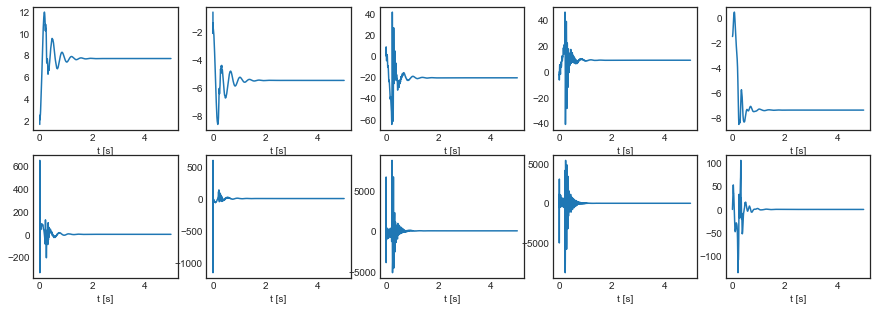

In [201]:
yi = yData.y
t = yData.t

plt.style.use('seaborn-white')

fig, axes = plt.subplots(2,int(len(yi)/2),figsize=(15,5))

for i in range(int(len(yi)/2)):
    # pos plot
    axes[0][i].plot(t,yi[i*2])
    axes[0][i].set_ylabel('')
    axes[0][i].set_xlabel('t [s]')
    
    # vel plot
    axes[1][i].plot(t,yi[i*2+1])
    axes[1][i].set_ylabel('')
    axes[1][i].set_xlabel('t [s]')

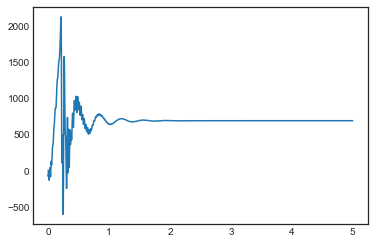

In [202]:
alp = [sm_mini.ExtForces.forces[1].GetAlpha(p.GetNumericTuple(i,0),i,0,0) for i in yi.T]
#plt.plot(t,np.rad2deg(alp))

func_tau = sym.lambdify((p.x,),tau_s0.subs(p.GetSubs([0]*p.qs*2,0)))
twist = [func_tau(i) for i in yi.T]
plt.plot(t,np.rad2deg(twist))

## Create the linearised EoM about some Stationary point

In [180]:
fwt_aoa = mf.GetAoA(p.alpha_r,0,p.Lambda.value,p.q[-1])

In [181]:
# Linearise the Symbolic model
p.fp.value = [0]*p.qs*2
p.fp.value[-2] = np.pi/2
p.eta.value = [1,1,1,1,1]
p.s_t.value = 1.5

# sub in functions!
sm_subbed = sm.subs(p,{p.alpha_1:p.alpha_1.value,p.alphadot_1:p.alphadot_1.value})

# get the linearised sm
sm_lin = sm_subbed.subs(p,p.GetSubs(0,p.fp,ignore=[p.V,p.GJ])).linearise(p)

# get eigen Matrices and turn into a function
K,M = sm_lin.eigenMatrices(p)

In [182]:
func = sym.lambdify((p.V,p.fp,p.GJ),(K,M),'numpy')

In [183]:
from scipy.linalg import eig
ev,evec = eig(*func(0,p.fp.value,800))
np.abs(ev)/(2*np.pi)
#np.real(ev)

array([235.3782853 , 235.3782853 ,  40.57507558,  40.57507558,
        14.77155202,  14.77155202,   6.42134749,   6.42134749,
         0.98237736,   0.98237736])

In [184]:
q = sym.Matrix(p.fp[::2])
qd = sym.Matrix(p.fp[1::2])
f = (sm_lin.f-sm_lin.ExtForces.Q())
f = (sm_lin.f-sm_lin.ExtForces.Q()).subs({p.x[i]:p.fp[i] for i in range(-1,-len(p.x)-1,-1)}).subs({i:0 for i in qd})
func_obj = sym.lambdify((q,p.V),(f.T*f).subs(p.GetSubs(0,q,ignore=[p.fp,p.V]))[0])


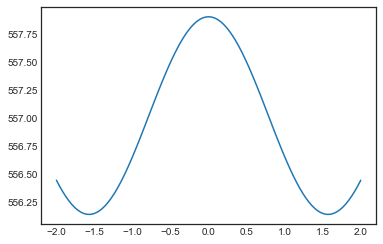

In [185]:
func_obj([0,0,0.1,0,-0.6],100)
theta = np.linspace(2,-2,101)
plt.plot(theta,[func_obj([0,0,0,0,i],0) for i in theta])

In [186]:
p.V.value = 0
from scipy.optimize import minimize

p0 = [0]*p.qs
p0[-1] = np.pi/2

minimize(func_obj,p0,args=(0),method='CG').x

array([-7.95316518e-03,  2.63714056e-03, -7.73465274e-09, -1.37921876e-08,
        1.57079633e+00])

In [187]:
p.GJ.value = 600

In [188]:
df = pd.DataFrame(columns=['v','aoa','q','Lambda'])
vs = np.linspace(0,250,121)
pLast = [0]*p.qs
pLast[-1] = np.pi/2
for v in vs:
    p.V.value = v 
    pLast = minimize(func_obj,pLast,method='Powell',args=(v)).x
    v0 = [0]*p.qs
    y0 = [j for i in range(len(p0)) for j in [pLast[i],v0[i]]]
    df = df.append({'aoa' : np.rad2deg(p.alpha_r(0,y0)), 'v' : v,'q':y0,'Lambda':np.rad2deg(p.Lambda.value)} , ignore_index=True)
    pLast
data = df

flutdfv2 = pd.DataFrame() 
for i in range(0,len(data)):  
    # get the fixed point
    #lp = [data['eta'].iloc[i],0,data['q1'].iloc[i],0]

    # get the jacobian evaluated at this point
    #j_lp = func(data['v'].iloc[i],np.deg2rad(data['Lambda'].iloc[i]),ratio,lp)
    # get eigen value information
    #jac_dat = dof2.ExtractEigenValueData(j_lp,sortby='Damping')
    evals, evecs = eig(*func(data['v'].iloc[i],data['q'].iloc[i],p.GJ.value))
    jac_dat = mf.ExtractEigenValueData(evals,evecs,sortby='Frequency')

    # populate test specific data   
    jac_dat['V'] = data['v'].iloc[i]
    #jac_dat['Mass Ratio'] = f'r = {ratio}'
    y = np.array(data['q'].iloc[i])
    for i in range(len(y)):
        jac_dat[f'q_{i}'] =y[i]
    jac_dat['Lambda'] = data['Lambda'].iloc[i]
    flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True)
flutdfv2   

,cn,Real,Imag,Frequency,Damping,Stable,Eigen Vector,Mode,V,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,q_9,Lambda
0,0.000000+6.171982j,0.000000,6.171982,0.982301,6.123234e-17,True,"[7.682983238228385e-06j, -2.299343715711523e-0...",0,0.0,-0.006689,0.0,0.001988,0.0,0.000004,0.0,-0.000003,0.0,1.553375,0.0,10.0
1,0.000000+39.028584j,0.000000,39.028584,6.211592,6.123234e-17,True,"[-0.013834838451971266j, 0.004506004435069519j...",1,0.0,-0.006689,0.0,0.001988,0.0,0.000004,0.0,-0.000003,0.0,1.553375,0.0,10.0
2,0.000000+83.339888j,0.000000,83.339888,13.263955,6.123234e-17,True,"[0.002080682686629226j, -0.0004146890552271384...",2,0.0,-0.006689,0.0,0.001988,0.0,0.000004,0.0,-0.000003,0.0,1.553375,0.0,10.0
3,0.000000+221.579642j,0.000000,221.579642,35.265495,6.123234e-17,True,"[0.00026676597649580644j, -0.00016092811277785...",3,0.0,-0.006689,0.0,0.001988,0.0,0.000004,0.0,-0.000003,0.0,1.553375,0.0,10.0
4,0.000000+1469.409852j,0.000000,1469.409852,233.863841,6.123234e-17,True,"[-0.0003614466993101986j, 0.000324776348264972...",4,0.0,-0.006689,0.0,0.001988,0.0,0.000004,0.0,-0.000003,0.0,1.553375,0.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,-10.310839+0.000000j,-10.310839,0.000000,0.000000,NaN,False,"[(0.06033684834746797+0j), (-0.021285578428220...",1,250.0,1.638590,0.0,-0.575308,0.0,-0.048043,0.0,-0.089153,0.0,-1.478906,0.0,10.0
612,-9.802242+50.333280j,-9.802242,50.333280,8.161286,-1.911556e-01,False,[(-4.4702614869873135e-07-1.907526480666502e-0...,2,250.0,1.638590,0.0,-0.575308,0.0,-0.048043,0.0,-0.089153,0.0,-1.478906,0.0,10.0
613,-8.797396+136.506609j,-8.797396,136.506609,21.770772,-6.431324e-02,False,[(-0.00016841701890850884-0.000410130648627844...,3,250.0,1.638590,0.0,-0.575308,0.0,-0.048043,0.0,-0.089153,0.0,-1.478906,0.0,10.0
614,-7.887038+237.714970j,-7.887038,237.714970,37.854331,-3.316030e-02,False,[(6.614734699617148e-05+0.00037812003739343776...,4,250.0,1.638590,0.0,-0.575308,0.0,-0.048043,0.0,-0.089153,0.0,-1.478906,0.0,10.0


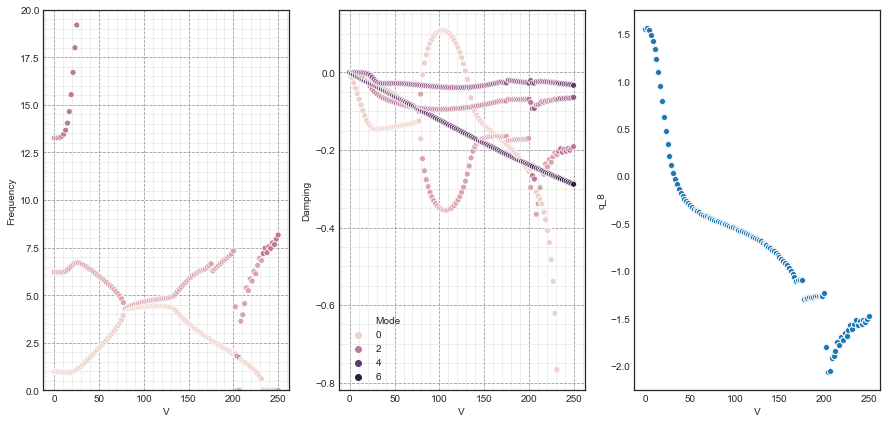

In [189]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
#data = flutdfv2[(flutdfv2['Stable'])]
#data = flutdfv2[flutdfv2['Lambda']==10]
data = flutdfv2
fig, axes = plt.subplots(1,3,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='Mode',ax=axes[0],legend=False)
sns.scatterplot(data=data,x='V',y='Damping',hue='Mode',ax=axes[1])
sns.scatterplot(data=data,x='V',y=f'q_{p.qs*2-2}',ax=axes[2])


#axes[1].annotate('Flutter Speed Constant',xy=(41, -0.01),  xycoords='data',
#            xytext=(40, -0.1),
#            arrowprops=dict(facecolor='black', shrink=0.01,width=1))

#axes[1].annotate('Below flutter speed FWTD stabilises \nthe other mode',xy=(30, -0.05),  xycoords='data',
#            xytext=(20, -0.18),
#            arrowprops=dict(facecolor='black', shrink=0.01,width=1))

#axes[1].annotate('Instability has a peak, and its magnitude is a function of mass ratio and flare angle ',xy=(40, 0.2),  xycoords='data',
#            xytext=(-3.5, 0.25),
#            arrowprops=dict(facecolor='black', shrink=0.01,width=1))

#sns.scatterplot(data=data,x='V',y='Damping',hue='Mass Ratio',style='Lambda',ax=axes[1],s=10,edgecolor = 'none')
for i in [0,1]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,60))
#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,20))